In [1]:
from __future__ import division, print_function
import sys, os, glob, time, warnings, gc
import numpy as np
import matplotlib.pyplot as plt
from astropy.table import Table, vstack, hstack, join
import fitsio
# from astropy.io import fits

In [2]:
params = {'legend.fontsize': 'large',
         'axes.labelsize': 'large',
         'axes.titlesize':'large',
         'xtick.labelsize':'large',
         'ytick.labelsize':'large',
         'figure.facecolor':'w'} 
plt.rcParams.update(params)

In [3]:
def binned_frac(x, y, bin_edges, minsize=10, error_floor=True):
    bin_center = (bin_edges[1:] + bin_edges[:-1])/2
    bin_frac = np.zeros(len(bin_edges)-1)
    bin_frac_err = np.zeros(len(bin_edges)-1)
    for index in range(len(bin_edges)-1):
        mask = (x>bin_edges[index]) & (x<=bin_edges[index+1])
        if np.sum(mask)<minsize:
            bin_frac[index] = np.nan
            bin_frac_err[index] = np.nan
        else:
            n, p = np.sum(mask), np.mean(y[mask])
            if error_floor:
                p1 = np.maximum(p, 1/n)  # error floor
            else:
                p1 = p
            bin_frac[index] = p
            bin_frac_err[index] = np.clip(np.sqrt(n * p * (1-p))/n, np.sqrt(n * p1 * (1-p1))/n, 1)
    
    return bin_center, bin_frac, bin_frac_err

In [4]:
cat = Table(fitsio.read('/global/cfs/cdirs/desi/users/rongpu/spectro/daily/main_done_cumulative_lrg_good_20211027.fits'))
print(len(cat))

153297


In [5]:
# cat['EFFTIME_ELG'] = 8.60 * cat['TSNR2_ELG']
cat['EFFTIME_LRG'] = 12.15 * cat['TSNR2_LRG']

# Remove FIBERSTATUS!=0 fibers
mask = cat['COADD_FIBERSTATUS']==0
print('FIBERSTATUS',np.sum(mask), np.sum(~mask), np.sum(~mask)/len(mask))
cat = cat[mask]

# Remove "no data" fibers
mask = cat['ZWARN'] & 2**9==0
print('No data', np.sum(mask), np.sum(~mask), np.sum(~mask)/len(mask))
cat = cat[mask]

# Apply LRG mask
mask = cat['lrg_mask']==0
print('LRG mask', np.sum(mask), np.sum(~mask), np.sum(~mask)/len(mask))
cat = cat[mask]

# Remove QSO targets
mask = cat['DESI_TARGET'] & 2**2 ==0
print('Remove QSO targets', np.sum(mask), np.sum(~mask), np.sum(~mask)/len(mask))
cat = cat[mask]

# Require a minimum depth
min_depth = 800.
mask = cat['EFFTIME_LRG']>min_depth
print('Min depth', np.sum(mask), np.sum(~mask), np.sum(mask)/len(mask))
cat = cat[mask]

# Julien's bad fibers list
bad_fibers = np.array(Table.read('/global/cfs/cdirs/desi/users/rongpu/spectro/everest/misc/badfibers.csv')['FIBER'])
# bad_fibers = np.array(Table.read('/Users/rongpu/Documents/Data/desi_data/everest/misc/badfibers.csv')['FIBER'])
bad_fibers = np.append(bad_fibers, np.arange(2663, 2674+1))  # fibers affected by the CCD z5 defect
bad_fibers = np.append(bad_fibers, [3402, 3429])  # "swapped" fibers
bad_fibers = np.unique(bad_fibers)
print(len(bad_fibers), 'bad fibers')
mask_bad = np.in1d(cat['FIBER'], bad_fibers)
print('Bad fibers', np.sum(~mask_bad), np.sum(mask_bad), np.sum(mask_bad)/len(mask_bad))
cat = cat[~mask_bad]

# Remove duplidates keeping the higher EFFTIME objects
print(len(cat), len(np.unique(cat['TARGETID'])), len(cat)-len(np.unique(cat['TARGETID'])))
cat.sort('EFFTIME_LRG', reverse=True)
_, idx_keep = np.unique(cat['TARGETID'], return_index=True)
cat = cat[idx_keep]
print(len(cat), len(np.unique(cat['TARGETID'])), len(cat)-len(np.unique(cat['TARGETID'])))

print(len(cat))

FIBERSTATUS 151843 1454 0.009484856194185144
No data 151840 3 1.9757249264042465e-05
LRG mask 138919 12921 0.08509615384615385
Remove QSO targets 137477 1442 0.010380149583570282
Min depth 125446 12031 0.9124871796736909
199 bad fibers
Bad fibers 120998 4448 0.03545748768394369
120998 118985 2013
118985 118985 0
118985


In [6]:
mask = cat['TARGET_DEC']<15
cat = cat[mask]
print(len(cat))

116095


In [7]:
mask = (cat['EFFTIME_LRG']>800) & (cat['EFFTIME_LRG']<1200)
cat = cat[mask]
print(len(cat))

105640


In [8]:
mask = ~np.in1d(cat['PETAL_LOC'], [1, 4, 5, 8])
cat = cat[mask]
print(len(cat))
print(list(np.unique(cat['PETAL_LOC'])))

64123
[0, 2, 3, 6, 7, 9]


In [9]:
# mask = cat['COADD_NUMEXP']==1
# cat = cat[mask]
# print(len(cat))

-----

In [10]:
exp = Table.read('/global/cfs/cdirs/desi/spectro/redux/daily/exposures-daily.csv')
print(len(exp))

mask = exp['EXPTIME']>400
exp = exp[mask]
print(len(exp))

mask = np.in1d(exp['TILEID'], cat['TILEID'])
exp = exp[mask]
print(len(exp))

5271
3364
136


In [11]:
print(len(exp), len(np.unique(exp['TILEID'])), len(np.unique(cat['TILEID'])))

136 116 116


In [12]:
# t = Table()
# t['TILEID'], t['count'] = np.unique(exp['TILEID'], return_counts=True)
# t.sort('count')
# mask = t['count']>1
# t[mask]

# mask = exp['TILEID']==t['TILEID'][mask][0]
# exp[mask]

In [13]:
# For coadds of multiple exposures, only keep the longest exposure
exp.sort('EXPTIME', reverse=True)
_, idx_keep = np.unique(exp['TILEID'], return_index=True)

exp1 = exp[idx_keep]
print(len(exp1), len(np.unique(exp1['TILEID'])))

116 116


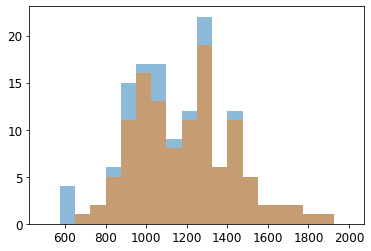

In [14]:
plt.hist(exp['EXPTIME'], 20, range=(500, 2000), alpha=0.5)
plt.hist(exp1['EXPTIME'], 20, range=(500, 2000), alpha=0.5)
plt.show()

In [15]:
exp = exp1

In [16]:
exp = exp[['TILEID', 'AIRMASS', 'SEEING_ETC', 'TRANSPARENCY_GFA', 'SEEING_GFA', 'AIRMASS_GFA', 'SKY_MAG_AB_GFA', 'SKY_MAG_G_SPEC', 'SKY_MAG_R_SPEC', 'SKY_MAG_Z_SPEC']]

print(len(cat))
cat = join(cat, exp, keys='TILEID')
print(len(cat))

64123
64123


--------

In [17]:
# Custom DELTACHI2 vs z cut
d = (10**(3 - 3.5*cat['Z']))
mask_remove = (d>30) & (cat['DELTACHI2']<30)
mask_remove |= (d<30) & (cat['DELTACHI2']<d)
mask_remove |= (cat['DELTACHI2']<10)
mask_quality = cat['ZWARN']==0
mask_quality &= cat['Z']<1.4
mask_quality &= (~mask_remove)

print(np.sum(~mask_quality)/len(mask_quality))

0.017029770909034198


In [18]:
cat['speed'] = cat['EFFTIME_LRG']*10**(2*2.165*cat['EBV']/2.5)/cat['COADD_EXPTIME']
# cat['speed_noebv'] = cat['EFFTIME_LRG']/cat['COADD_EXPTIME']

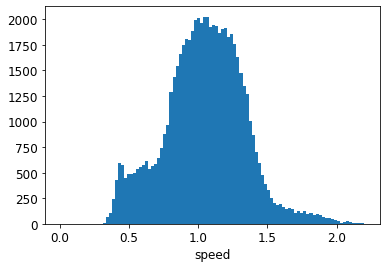

In [19]:
plt.hist(cat['speed'], 100, range=(0, 2.2))
# plt.axvline(0.7, ls='--', color='k')
plt.xlabel('speed')
plt.show()

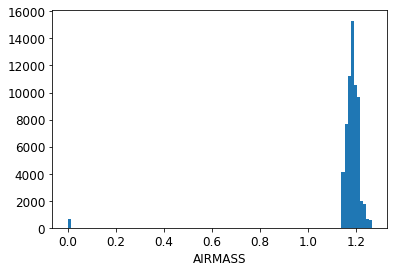

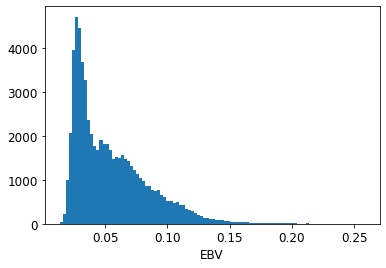

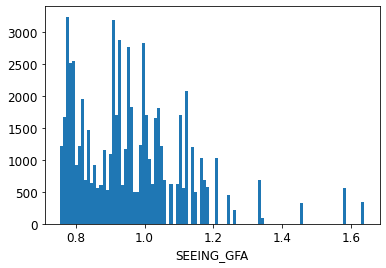

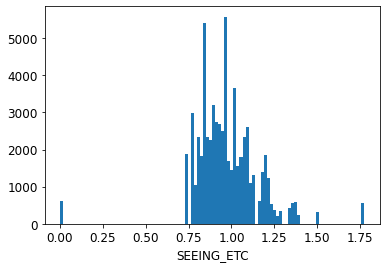

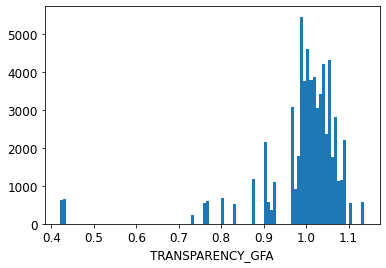

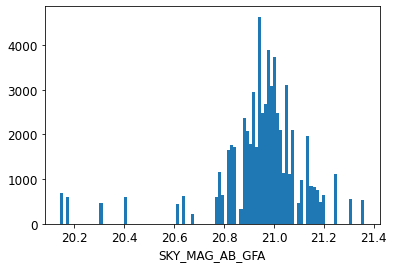

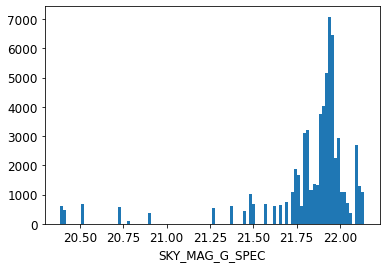

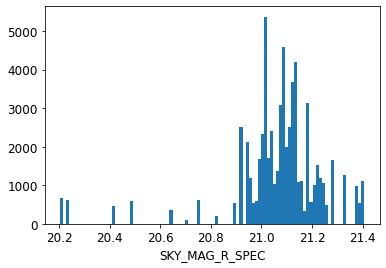

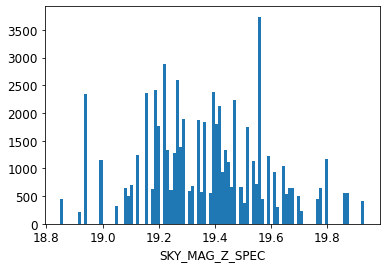

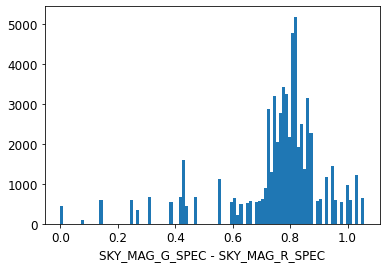

In [21]:
plt.hist(cat['AIRMASS'], 100)
plt.xlabel('AIRMASS')
plt.show()

plt.hist(cat['EBV'], 100)
plt.xlabel('EBV')
plt.show()

plt.hist(cat['SEEING_GFA'], 100)
plt.xlabel('SEEING_GFA')
plt.show()

plt.hist(cat['SEEING_ETC'], 100)
plt.xlabel('SEEING_ETC')
plt.show()

plt.hist(cat['TRANSPARENCY_GFA'], 100)
plt.xlabel('TRANSPARENCY_GFA')
plt.show()

plt.hist(cat['SKY_MAG_AB_GFA'], 100)
plt.xlabel('SKY_MAG_AB_GFA')
plt.show()

plt.hist(cat['SKY_MAG_G_SPEC'], 100)
plt.xlabel('SKY_MAG_G_SPEC')
plt.show()

plt.hist(cat['SKY_MAG_R_SPEC'], 100)
plt.xlabel('SKY_MAG_R_SPEC')
plt.show()

plt.hist(cat['SKY_MAG_Z_SPEC'], 100)
plt.xlabel('SKY_MAG_Z_SPEC')
plt.show()

plt.hist(cat['SKY_MAG_G_SPEC']-cat['SKY_MAG_R_SPEC'], 100)
plt.xlabel('SKY_MAG_G_SPEC - SKY_MAG_R_SPEC')
plt.show()

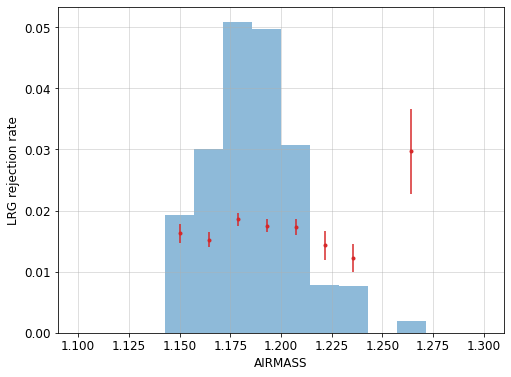

In [21]:
mask = np.full(len(cat), True)
bin_edges = np.linspace(1.1, 1.3, 15)
bin_center, bin_reject_rate, bin_reject_rate_err = binned_frac(cat['AIRMASS'][mask], (~mask_quality)[mask], bin_edges, minsize=10)

plt.figure(figsize=(8, 6))
plt.errorbar(bin_center, bin_reject_rate, color='C3',
             yerr=(np.clip(bin_reject_rate_err, None, bin_reject_rate), bin_reject_rate_err),
             fmt='.', label=None)
plt.xlabel('AIRMASS')
plt.ylabel('LRG rejection rate')
plt.grid(alpha=0.5)
# plt.legend(loc='upper right')
# plt.axis([0.0, 2., 0., 0.05])
plt.hist(cat['AIRMASS'], bins=bin_edges, weights=np.full(len(cat), 0.2*1/len(cat)), alpha=0.5)
plt.show()

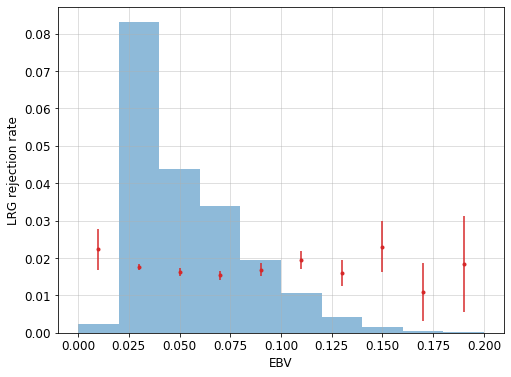

In [22]:
mask = np.full(len(cat), True)
bin_edges = np.linspace(0., 0.2, 11)
bin_center, bin_reject_rate, bin_reject_rate_err = binned_frac(cat['EBV'][mask], (~mask_quality)[mask], bin_edges, minsize=10)

plt.figure(figsize=(8, 6))
plt.errorbar(bin_center, bin_reject_rate, color='C3',
             yerr=(np.clip(bin_reject_rate_err, None, bin_reject_rate), bin_reject_rate_err),
             fmt='.', label=None)
plt.xlabel('EBV')
plt.ylabel('LRG rejection rate')
plt.grid(alpha=0.5)
# plt.legend(loc='upper right')
# plt.axis([0.0, 2., 0., 0.05])
plt.hist(cat['EBV'], bins=bin_edges, weights=np.full(len(cat), 0.2*1/len(cat)), alpha=0.5)
plt.show()

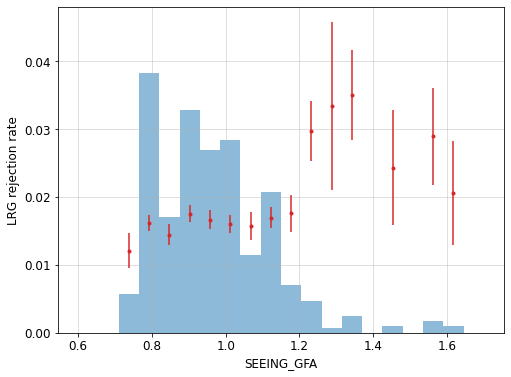

In [23]:
mask = np.full(len(cat), True)
bin_edges = np.linspace(0.6, 1.7, 21)
bin_center, bin_reject_rate, bin_reject_rate_err = binned_frac(cat['SEEING_GFA'][mask], (~mask_quality)[mask], bin_edges, minsize=10)

plt.figure(figsize=(8, 6))
plt.errorbar(bin_center, bin_reject_rate, color='C3',
             yerr=(np.clip(bin_reject_rate_err, None, bin_reject_rate), bin_reject_rate_err),
             fmt='.', label=None)
plt.xlabel('SEEING_GFA')
plt.ylabel('LRG rejection rate')
plt.grid(alpha=0.5)
# plt.legend(loc='upper right')
# plt.axis([0.0, 2., 0., 0.05])
plt.hist(cat['SEEING_GFA'], bins=bin_edges, weights=np.full(len(cat), 0.2*1/len(cat)), alpha=0.5)
plt.show()

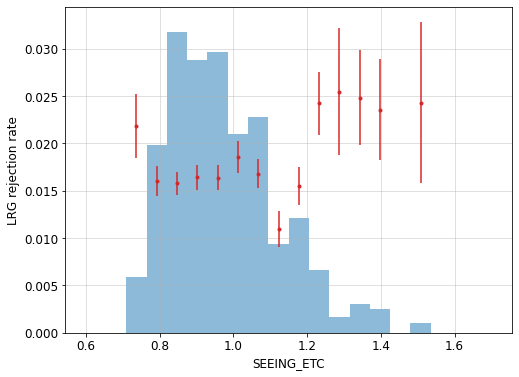

In [24]:
mask = np.full(len(cat), True)
bin_edges = np.linspace(0.6, 1.7, 21)
bin_center, bin_reject_rate, bin_reject_rate_err = binned_frac(cat['SEEING_ETC'][mask], (~mask_quality)[mask], bin_edges, minsize=10)

plt.figure(figsize=(8, 6))
plt.errorbar(bin_center, bin_reject_rate, color='C3',
             yerr=(np.clip(bin_reject_rate_err, None, bin_reject_rate), bin_reject_rate_err),
             fmt='.', label=None)
plt.xlabel('SEEING_ETC')
plt.ylabel('LRG rejection rate')
plt.grid(alpha=0.5)
# plt.legend(loc='upper right')
# plt.axis([0.0, 2., 0., 0.05])
plt.hist(cat['SEEING_ETC'], bins=bin_edges, weights=np.full(len(cat), 0.2*1/len(cat)), alpha=0.5)
plt.show()

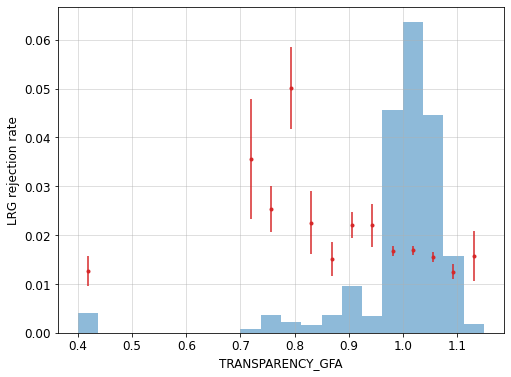

In [25]:
mask = np.full(len(cat), True)
bin_edges = np.linspace(0.4, 1.15, 21)
bin_center, bin_reject_rate, bin_reject_rate_err = binned_frac(cat['TRANSPARENCY_GFA'][mask], (~mask_quality)[mask], bin_edges, minsize=10)

plt.figure(figsize=(8, 6))
plt.errorbar(bin_center, bin_reject_rate, color='C3',
             yerr=(np.clip(bin_reject_rate_err, None, bin_reject_rate), bin_reject_rate_err),
             fmt='.', label=None)
plt.xlabel('TRANSPARENCY_GFA')
plt.ylabel('LRG rejection rate')
plt.grid(alpha=0.5)
# plt.legend(loc='upper right')
# plt.axis([0.0, 2., 0., 0.05])
plt.hist(cat['TRANSPARENCY_GFA'], bins=bin_edges, weights=np.full(len(cat), 0.2*1/len(cat)), alpha=0.5)
plt.show()

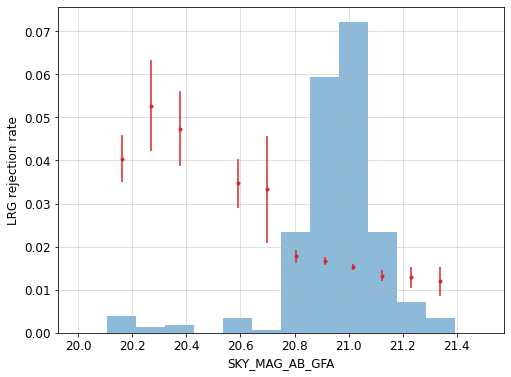

In [26]:
mask = np.full(len(cat), True)
bin_edges = np.linspace(20., 21.5, 15)
bin_center, bin_reject_rate, bin_reject_rate_err = binned_frac(cat['SKY_MAG_AB_GFA'][mask], (~mask_quality)[mask], bin_edges, minsize=10)

plt.figure(figsize=(8, 6))
plt.errorbar(bin_center, bin_reject_rate, color='C3',
             yerr=(np.clip(bin_reject_rate_err, None, bin_reject_rate), bin_reject_rate_err),
             fmt='.', label=None)
plt.xlabel('SKY_MAG_AB_GFA')
plt.ylabel('LRG rejection rate')
plt.grid(alpha=0.5)
# plt.legend(loc='upper right')
# plt.axis([0.0, 2., 0., 0.05])
plt.hist(cat['SKY_MAG_AB_GFA'], bins=bin_edges, weights=np.full(len(cat), 0.2*1/len(cat)), alpha=0.5)
plt.show()

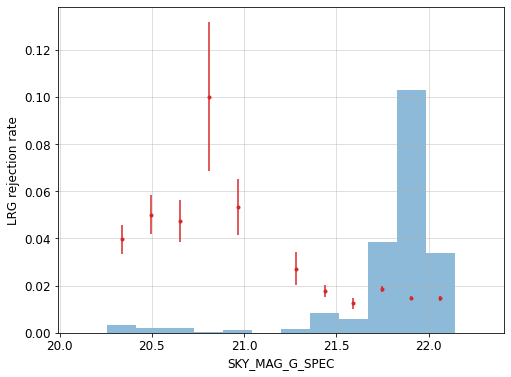

In [29]:
mask = np.full(len(cat), True)
bin_edges = np.linspace(20.1, 22.3, 15)
bin_center, bin_reject_rate, bin_reject_rate_err = binned_frac(cat['SKY_MAG_G_SPEC'][mask], (~mask_quality)[mask], bin_edges, minsize=10)

plt.figure(figsize=(8, 6))
plt.errorbar(bin_center, bin_reject_rate, color='C3',
             yerr=(np.clip(bin_reject_rate_err, None, bin_reject_rate), bin_reject_rate_err),
             fmt='.', label=None)
plt.xlabel('SKY_MAG_G_SPEC')
plt.ylabel('LRG rejection rate')
plt.grid(alpha=0.5)
# plt.legend(loc='upper right')
# plt.axis([0.0, 2., 0., 0.05])
plt.hist(cat['SKY_MAG_G_SPEC'], bins=bin_edges, weights=np.full(len(cat), 0.2*1/len(cat)), alpha=0.5)
plt.show()

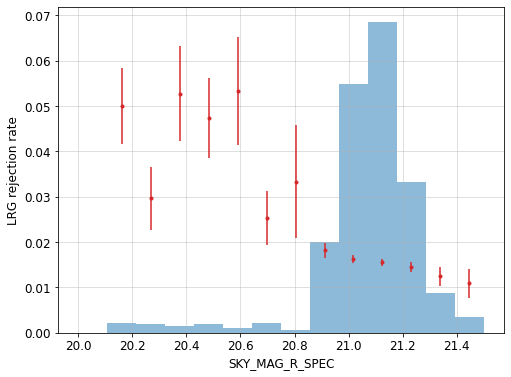

In [24]:
mask = np.full(len(cat), True)
bin_edges = np.linspace(20., 21.5, 15)
bin_center, bin_reject_rate, bin_reject_rate_err = binned_frac(cat['SKY_MAG_R_SPEC'][mask], (~mask_quality)[mask], bin_edges, minsize=10)

plt.figure(figsize=(8, 6))
plt.errorbar(bin_center, bin_reject_rate, color='C3',
             yerr=(np.clip(bin_reject_rate_err, None, bin_reject_rate), bin_reject_rate_err),
             fmt='.', label=None)
plt.xlabel('SKY_MAG_R_SPEC')
plt.ylabel('LRG rejection rate')
plt.grid(alpha=0.5)
# plt.legend(loc='upper right')
# plt.axis([0.0, 2., 0., 0.05])
plt.hist(cat['SKY_MAG_R_SPEC'], bins=bin_edges, weights=np.full(len(cat), 0.2*1/len(cat)), alpha=0.5)
plt.show()

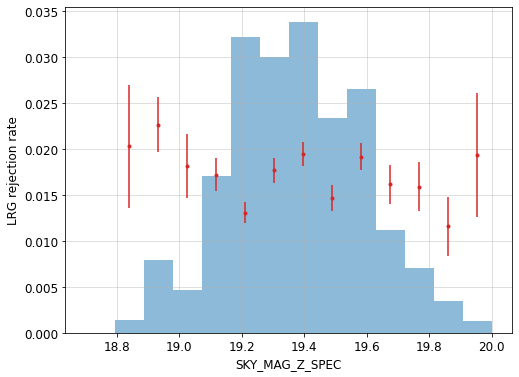

In [28]:
mask = np.full(len(cat), True)
bin_edges = np.linspace(18.7, 20., 15)
bin_center, bin_reject_rate, bin_reject_rate_err = binned_frac(cat['SKY_MAG_Z_SPEC'][mask], (~mask_quality)[mask], bin_edges, minsize=10)

plt.figure(figsize=(8, 6))
plt.errorbar(bin_center, bin_reject_rate, color='C3',
             yerr=(np.clip(bin_reject_rate_err, None, bin_reject_rate), bin_reject_rate_err),
             fmt='.', label=None)
plt.xlabel('SKY_MAG_Z_SPEC')
plt.ylabel('LRG rejection rate')
plt.grid(alpha=0.5)
# plt.legend(loc='upper right')
# plt.axis([0.0, 2., 0., 0.05])
plt.hist(cat['SKY_MAG_Z_SPEC'], bins=bin_edges, weights=np.full(len(cat), 0.2*1/len(cat)), alpha=0.5)
plt.show()

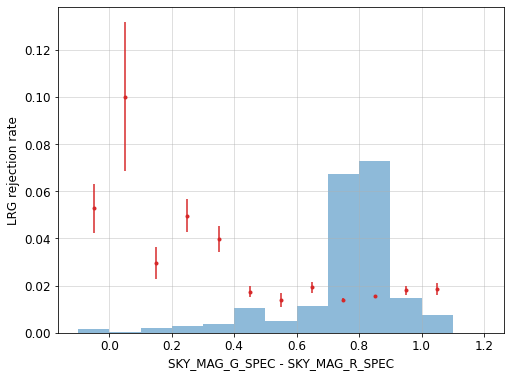

In [52]:
mask = np.full(len(cat), True)
bin_edges = np.linspace(-0.1, 1.2, 14)
bin_center, bin_reject_rate, bin_reject_rate_err = binned_frac((cat['SKY_MAG_G_SPEC']-cat['SKY_MAG_R_SPEC'])[mask], (~mask_quality)[mask], bin_edges, minsize=10)

plt.figure(figsize=(8, 6))
plt.errorbar(bin_center, bin_reject_rate, color='C3',
             yerr=(np.clip(bin_reject_rate_err, None, bin_reject_rate), bin_reject_rate_err),
             fmt='.', label=None)
plt.xlabel('SKY_MAG_G_SPEC - SKY_MAG_R_SPEC')
plt.ylabel('LRG rejection rate')
plt.grid(alpha=0.5)
# plt.legend(loc='upper right')
# plt.axis([0.0, 2., 0., 0.05])
plt.hist((cat['SKY_MAG_G_SPEC']-cat['SKY_MAG_R_SPEC']), bins=bin_edges, weights=np.full(len(cat), 0.2*1/len(cat)), alpha=0.5)
plt.show()